In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import pickle
import glob
from tqdm import tqdm

## Cargar diagramas de persistencia de ondas gravitacionales

In [4]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
import glob

# Función para cargar los diagramas de persistencia de un archivo
def load_persistence_diagrams(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Función para extraer vectores de persistencia
def extract_persistence_vectors(diagrams, max_length):
    persistence_vectors = np.zeros((2, max_length))
    for dim in range(2):
        for i, (birth, death) in enumerate(diagrams[dim]):
            if i < max_length:
                persistence_vectors[dim, i] = death - birth
    return persistence_vectors.flatten()

# Función para determinar la longitud máxima de los vectores de persistencia
def determine_max_persistence_length(diagrams, percentile=95):
    lengths = []
    for diagram in diagrams:
        for dim in range(len(diagram)):
            lengths.append(len(diagram[dim]))
    return int(np.percentile(lengths, percentile))

# Cargar todos los diagramas de persistencia guardados
all_persistence_diagrams = []
for file in sorted(glob.glob('persistence_diagrams_block_*.pkl')):
    diagrams = load_persistence_diagrams(file)
    all_persistence_diagrams.extend(diagrams)

# Determinar el max_persistence_length basado en los diagramas de persistencia cargados
max_persistence_length = determine_max_persistence_length(all_persistence_diagrams, percentile=95)
print(f"Longitud máxima de persistencia determinada: {max_persistence_length}")

# Limitar manualmente la longitud máxima de persistencia si es demasiado grande
max_persistence_length = min(max_persistence_length, 500)  # Ajusta este valor según sea necesario

# Extraer y normalizar los vectores de persistencia
persistence_vectors = [extract_persistence_vectors(d, max_persistence_length) for d in all_persistence_diagrams]

# Filtrar valores grandes e infinitos
persistence_vectors = np.array(persistence_vectors)
persistence_vectors[np.isinf(persistence_vectors)] = np.nan
persistence_vectors = np.nan_to_num(persistence_vectors, nan=0.0, posinf=0.0, neginf=0.0)

# Normalizar los vectores de persistencia
scaler = StandardScaler()
normalized_persistence_vectors = scaler.fit_transform(persistence_vectors)

# Supongamos que las señales crudas ya están normalizadas y almacenadas en `training_data`
# Normalizar las señales crudas (si no lo están)
normalized_signals = [scaler.fit_transform(s.reshape(-1, 1)).flatten() for s in training_data]

# Concatenar los vectores de persistencia y las señales crudas
input_data = [np.concatenate((psv, sig)) for psv, sig in zip(normalized_persistence_vectors, normalized_signals)]

# Convertir los datos de entrada a formato numpy array
input_data = np.array(input_data)

# Crear etiquetas ficticias para la demostración
labels = np.array([1 if i % 2 == 0 else 0 for i in range(len(input_data))])

# Dividir en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(input_data))
x_train, x_test = input_data[:train_size], input_data[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Redimensionar los datos para la entrada de la CNN
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]



Longitud máxima de persistencia determinada: 3897


In [5]:
# Verificar la distribución de las etiquetas
unique, counts = np.unique(labels, return_counts=True)
print(f"Distribución de etiquetas: {dict(zip(unique, counts))}")


Distribución de etiquetas: {0: 208, 1: 208}


In [6]:
# Ajustar el número de épocas y la tasa de aprendizaje
from tensorflow.keras.optimizers import Adam

# Definir el modelo
model = Sequential([
    Conv1D(filters=64, kernel_size=16, strides=1, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(filters=128, kernel_size=16, strides=1, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(filters=256, kernel_size=16, strides=1, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Cambiar la activación a sigmoid para clasificación binaria
])

# Compilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Cambiar la pérdida a binary_crossentropy

# Resumen del modelo
model.summary()

# Entrenar el modelo con más épocas
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test))

# Evaluar el modelo
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5081, 64)          1088      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1270, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1255, 128)         131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 313, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 298, 256)          524544    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 74, 256)           0

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Predicciones del modelo
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Reporte de Clasificación
print(classification_report(y_test, y_pred))


3/3 [==============================] - 0s 3ms/step
[[39  3]
 [11 31]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        42
           1       0.91      0.74      0.82        42

    accuracy                           0.83        84
   macro avg       0.85      0.83      0.83        84
weighted avg       0.85      0.83      0.83        84



3/3 [==============================] - 0s 3ms/step


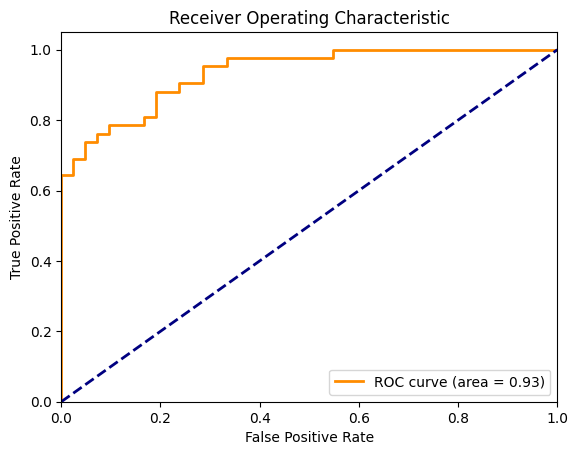

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predicciones de probabilidad
y_prob = model.predict(x_test).ravel()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
